## Importing and installing

In [ ]:
! pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.7 MB/s eta 0:00:00


In [ ]:
import mne
import zipfile
import os
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from mne import pick_types

## Loading datasets

In [ ]:
def read_parquet_eeg(parquet_file, sfreq):
    df = pd.read_parquet(parquet_file)
    eeg_data = df.drop(columns=['EKG']).to_numpy()
    channel_names = df.drop(columns=['EKG']).columns.tolist()

    info = mne.create_info(channel_names, sfreq, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data.T, info)
    return raw

In [ ]:
def load_eeg_data(eeg_file, sfreq):
    """
    Load EEG data from file using MNE-Python and extract detailed metadata.

    Args:
        eeg_file (str): Path to the EEG file.

    Returns:
        raw (mne.io.Raw): MNE-Python Raw object containing EEG data.
        metadata (dict): Dictionary containing metadata about the EEG recording.
    """
    file_extension = eeg_file.split('.')[-1].lower()

    if file_extension == 'edf':
        raw = mne.io.read_raw_edf(eeg_file, preload=True)
    elif file_extension == 'bdf':
        raw = mne.io.read_raw_bdf(eeg_file, preload=True)
    elif file_extension == 'vhdr':
        raw = mne.io.read_raw_brainvision(eeg_file, preload=True)
    elif file_extension == 'cnt':
        raw = mne.io.read_raw_cnt(eeg_file, preload=True)
    elif file_extension == 'fif':
        raw = mne.io.read_raw_fif(eeg_file, preload=True)
    elif file_extension == 'xdf':
        raw = mne.io.read_raw_xdf(eeg_file, preload=True)
    elif file_extension == 'mff':
        raw = mne.io.read_raw_egi(eeg_file, preload=True)
    elif file_extension == 'parquet':
        raw = read_parquet_eeg(eeg_file, sfreq)
    # elif file_extension == 'csv':
    #     raw = read_csv_eeg(eeg_file, sfreq)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")

    return raw


## Analysis

In [ ]:
def calculate_noise_to_signal_ratio(raw):
    data = raw.get_data()
    signal_power = np.mean(np.var(data, axis=1))

    # Estimate noise power (e.g., using baseline periods or specific channels)
    # For example, using baseline period as noise estimate:
    baseline_data = data[:, raw.times < 0]  # Assuming baseline is before time 0
    noise_power = np.mean(np.var(baseline_data, axis=1))
    nsr = noise_power / signal_power

    return nsr


The term "nondominant background activity" refers to the background electrocerebral activity in the EEG recording that is not the primary or dominant rhythm, which typically corresponds to the posterior dominant rhythm (also known as the alpha rhythm). The nondominant background activity includes other frequency components such as beta, theta, and delta waves, which are important to characterize and analyze in EEG recordings.



In [ ]:
def calculate_band_power(raw, sfreq, channel_data):
    # Define frequency bands of interest
    freq_bands = {'delta': (1, 4),
                  'theta': (4, 8),
                  'alpha': (8, 13),
                  'beta': (13, 30)}

    # Calculate PSD using Welch's method (psd_array_welch)
    psds, freqs = mne.time_frequency.psd_array_welch(channel_data, sfreq=sfreq, fmin=0.5, fmax=30)

    # Calculate total power across all frequencies
    total_power = np.mean(psds, axis=-1)

    # Calculate relative power and band power in different frequency bands
    relative_power = {}
    band_power = {}
    for band, (fmin, fmax) in freq_bands.items():
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        power_in_band = np.mean(psds[:, idx_band], axis=-1)
        relative_power[band] = power_in_band / total_power
        band_power[band] = power_in_band
    # print(relative_power)
    # print(band_power)
    return relative_power, band_power

def determine_dominant_rhythm(band_power):
    # Dictionary to store mean power for each frequency band
    mean_power = {}

    # Calculate mean power for each frequency band
    for band, power_array in band_power.items():
        mean_power[band] = np.mean(power_array)

    # Determine dominant rhythm based on maximum mean power
    dominant_rhythm = max(mean_power, key=mean_power.get)
    dominant_power = mean_power[dominant_rhythm]

    return dominant_rhythm, dominant_power



In [ ]:
def check_symmetry(raw):
    """
    Check symmetry of EEG data across channels.

    Args:
    - raw (mne.io.Raw): MNE Raw object containing EEG data.

    Returns:
    - symmetry_score (float): Symmetry score indicating the degree of symmetry.
                             A value closer to 1.0 indicates higher symmetry.
    """
    # Get the EEG data array from the Raw object
    eeg_data = raw.get_data()
    num_samples, num_channels = eeg_data.shape

    # Calculate mean absolute differences between all channel pairs
    abs_diff_sum = 0.0
    num_pairs = 0

    for i in tqdm(range(num_channels)):
        for j in range(i + 1, num_channels):
            channel_pair_diff = np.abs(eeg_data[:, i] - eeg_data[:, j])
            abs_diff_sum += np.mean(channel_pair_diff)
            num_pairs += 1

    # Calculate average absolute difference across all channel pairs
    if num_pairs > 0:
        mean_abs_diff = abs_diff_sum / num_pairs
    else:
        mean_abs_diff = 0.0

    # Calculate symmetry score (normalized measure of similarity)
    symmetry_score = 1.0 / (1.0 + mean_abs_diff)

    return symmetry_score


In [ ]:
def replace_nan_with_column_mean(data):
    column_means = np.nanmean(data, axis=0)
    nan_indices = np.isnan(data)

    # Replace NaN values with corresponding column means
    data[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

    return data

### Unsupervised Techniques to understand patterns

https://www.nature.com/articles/s41598-019-53925-5#:~:text=In%20this%20paper%2C%20we%20present,spectrum%20of%20the%20normalized%20iEEG

Analyzing common spectral features of iEEG data, the algorithm can distinguish between electrodes that are actively involved in brain processes (e.g., supporting verbal memory) versus those that are less involved or inactive.


### Basic Analysis

In [ ]:
def analyze_eeg(raw):

    #preprocessing
    raw.filter(0.5, 40)

    # Parameters for EEG analysis
    duration = raw.times[-1]  # Total duration of the recording in seconds
    sfreq = raw.info['sfreq']  # Sampling frequency
    n_channels = raw.info['nchan']  # Number of channels
    ch_names = raw.info['ch_names']  # Channel names

    # Extract features for EEG analysis
    data = raw.get_data()  # Get EEG data as a numpy array
    channel_data = data[:20, :]  # Select first 20 channels for analysis
    nsr_value = calculate_noise_to_signal_ratio(raw)

    # Replace NaN values with column mean
    channel_data = replace_nan_with_column_mean(channel_data)

    # Extract date of acquisition from metadata
    date_acquisition = raw.info['meas_date']
    if(date_acquisition is not None):
        date_acquisition_str = date_acquisition.strftime("%Y-%m-%d %H:%M:%S")
    else :
        date_acquisition_str = "Unknown"


    # Event detection: Detect spikes and sharp waves
    spike_threshold = 5.0  # Adjust threshold based on signal characteristics
    sharp_wave_threshold = 3.0  # Adjust threshold based on signal characteristics

    spike_events = []
    sharp_wave_events = []

    for i, channel in enumerate(channel_data):
        # Find peaks corresponding to spikes and sharp waves
        spike_peaks, _ = find_peaks(channel, height=spike_threshold, distance=int(0.2*sfreq))
        sharp_wave_peaks, _ = find_peaks(channel, height=sharp_wave_threshold, distance=int(0.2*sfreq))

        # Store spike events
        for peak in spike_peaks:
            spike_events.append((i, peak))

        # Store sharp wave events
        for peak in sharp_wave_peaks:
            sharp_wave_events.append((i, peak))
        duration = raw.times[-1]  # Total duration of the recording in seconds
    sfreq = raw.info['sfreq']  # Sampling frequency
    n_channels = raw.info['nchan']  # Number of channels
    ch_names = raw.info['ch_names']  # Channel names
    lowpass_freq = raw.info['lowpass'] if 'lowpass' in raw.info.keys() else 'Not specified'
    highpass_freq = raw.info['highpass'] if 'highpass' in raw.info.keys() else 'Not specified'

    # Features for EEG Description
    relative_power, band_power = calculate_band_power(raw, sfreq, channel_data)
    dominant_rhythm, dominant_power = determine_dominant_rhythm(band_power)

    symmetry_score = check_symmetry(raw)

    # Generate EEG report
    report = f"EEG Report for {eeg_file_path}\n\n"
    report += f"Duration: {duration:.2f} seconds\n"
    report += f"Sampling Frequency: {sfreq} Hz\n"
    report += f"Number of Channels: {n_channels}\n"
    report += f"Channel Names: {', '.join(ch_names)}\n\n"
    report += f"Date of Acquisition: {date_acquisition_str}\n"
    report += f"Noise-to-Signal Ratio (NSR): {nsr_value:.4f}\n"
    report += f"Lowpass Filter Frequency: {lowpass_freq}\n"
    report += f"Highpass Filter Frequency: {highpass_freq}\n\n"

    report += "Background Activity:\n"
    report += "-------------------\n"
    # Print dominant rhythm and power
    report += f"Dominant Rhythm: {dominant_rhythm}\n"
    report += f"Dominant Power: {dominant_power:.2f}\n"
    report += f"Symmetry Score: {symmetry_score:.4f}\n\n\n"


    report += "Abnormal Features:\n"
    report += "------------------\n"
    if len(spike_events) > 0:
        report += f"Detected {len(spike_events)} spike events.\n"
    else:
        report += "No spike events detected.\n"

    if len(sharp_wave_events) > 0:
        report += f"Detected {len(sharp_wave_events)} sharp wave events.\n\n\n"
    else:
        report += "No sharp wave events detected.\n\n\n"

    report += "Relative Power in Frequency Bands:\n"
    report += "---------------------------------\n"
    for band, power in relative_power.items():
        report += f"{band.capitalize()} band relative power: {power.mean():.2f}\n"

    report += "Power in Frequency Bands:\n"
    report += "---------------------------------\n"
    for band, power in band_power.items():
        report += f"{band.capitalize()} band relative power: {power.mean():.2f}\n"



    return report, raw


In [ ]:
print("NORMAL REPORT")
eeg_file_path = '/data/1000913311.parquet'
eeg_data = load_eeg_data(eeg_file_path, 200)
eeg_report, raw = analyze_eeg(eeg_data)
print(eeg_report)
print()

NORMAL REPORT
Creating RawArray with float64 data, n_channels=19, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1321 samples (6.605 s)

Effective window size : 1.280 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: divide by zero encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10000/10000 [08:38<00:00, 19.28it/s]

EEG Report for /content/drive/MyDrive/Sreeja/Notebooks 1/Data/1000913311.parquet

Duration: 49.99 seconds
Sampling Frequency: 200.0 Hz
Number of Channels: 19
Channel Names: Fp1, F3, C3, P3, F7, T3, T5, O1, Fz, Cz, Pz, Fp2, F4, C4, P4, F8, T4, T6, O2

Date of Acquisition: Unknown
Noise-to-Signal Ratio (NSR): nan
Lowpass Filter Frequency: 40.0
Highpass Filter Frequency: 0.5

Background Activity:
-------------------
Dominant Rhythm: delta
Dominant Power: 14.08
Symmetry Score: 0.0537


Abnormal Features:
------------------
Detected 2859 spike events.
Detected 2985 sharp wave events.


Relative Power in Frequency Bands:
---------------------------------
Delta band relative power: 2.57
Theta band relative power: 0.44
Alpha band relative power: 0.34
Beta band relative power: 0.42
Power in Frequency Bands:
---------------------------------
Delta band relative power: 14.08
Theta band relative power: 2.14
Alpha band relative power: 1.57
Beta band relative power: 1.92




In [ ]:
print("SEIZURE REPORT")
eeg_file_path = '/data/1002197945.parquet'
seizure_data = load_eeg_data(eeg_file_path, 200)
eeg_report_seizure, raw_seizure = analyze_eeg(seizure_data)
print(eeg_report_seizure)

SEIZURE REPORT
Creating RawArray with float64 data, n_channels=19, n_times=13200
    Range : 0 ... 13199 =      0.000 ...    65.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1321 samples (6.605 s)

Effective window size : 1.280 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: divide by zero encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 37%|███▋      | 4947/13200 [09:06<15:11,  9.05it/s]


KeyboardInterrupt: 

### Understanding abnormalities using standard deviation and variance


In [ ]:
def detect_abnormal_eeg_std(raw, threshold=3.0):
    picks = pick_types(raw.info, meg=False, eeg=True)
    eeg_data, _ = raw[picks]

    # Compute standard deviation across time for each EEG channel
    std_values = np.std(eeg_data, axis=1)
    mean_std = np.mean(std_values)

    # Detect abnormal channels based on the threshold
    abnormal_channels = np.where(std_values > mean_std + threshold * np.std(std_values))[0]

    return std_values, abnormal_channels

def detect_abnormal_eeg_variance(raw, threshold=3.0):
    picks = pick_types(raw.info, meg=False, eeg=True)
    eeg_data, _ = raw[picks]

    # Compute variance across time for each EEG channel
    variance_values = np.var(eeg_data, axis=1)
    mean_variance = np.mean(variance_values)

    abnormal_channels = np.where(variance_values > mean_variance + threshold * np.std(variance_values))[0]
    return variance_values, abnormal_channels

def plot_abnormal_eeg_std(raw, abnormal_channels, st_values):
    plt.figure(figsize=(12, 6))
    plt.plot(st_values, label='Standard Deviation', color='blue')

    channel_names = raw.info['ch_names']

    num_channels = len(channel_names)
    plt.xticks(ticks=range(num_channels), labels=channel_names, rotation=45, ha='right')
    plt.xlabel('Channel Names')

    plt.ylabel('Standard Deviation')
    plt.title('EEG Standard Deviation Values')
    plt.legend()

    # Highlight abnormal channels
    plt.scatter(abnormal_channels, st_values[abnormal_channels], color='red', label='Abnormal Channels', zorder=5)
    plt.legend()

    plt.tight_layout()
    plt.show()

#Plot both normal and abnormal to compare
def plot_eeg_std_comparison(normal_raw, abnormal_raw, threshold, statistic):

    if statistic == 'std':
        # Detect standard deviation for normal EEG
        normal_std_values, _ = detect_abnormal_eeg_std(normal_raw, threshold)

        # Detect standard deviation for abnormal EEG
        abnormal_std_values, abnormal_channels = detect_abnormal_eeg_std(abnormal_raw, threshold)

    elif statistic == 'variance':
        # Detect variance for normal EEG
        normal_std_values, _ = detect_abnormal_eeg_variance(normal_raw, threshold)

        # Detect variance for abnormal EEG
        abnormal_std_values, abnormal_channels = detect_abnormal_eeg_variance(abnormal_raw, threshold)

    channel_names = normal_raw.info['ch_names']
    num_channels = len(channel_names)

    # Plotting normal EEG standard deviation
    plt.figure(figsize=(14, 6))
    plt.plot(normal_std_values, label='Normal EEG', color='blue', linestyle='--')

    # Plotting abnormal EEG standard deviation
    plt.plot(abnormal_std_values, label='Abnormal EEG', color='red')

    # Highlight abnormal channels in the abnormal EEG plot
    plt.scatter(abnormal_channels, abnormal_std_values[abnormal_channels], color='red', label='Abnormal Channels', zorder=5)

    plt.xticks(ticks=range(num_channels), labels=channel_names, rotation=45, ha='right')
    plt.xlabel('Channel Names')

    plt.ylabel('Standard Deviation')
    plt.title(f'Comparison of EEG {statistic} (Normal vs Abnormal)')

    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
threshold = 2.0
std_values, abnormal_channels = detect_abnormal_eeg_std(raw, threshold)
plot_abnormal_eeg_std(raw, abnormal_channels, std_values)

In [ ]:
threshold = 2.0
std_values, abnormal_channels = detect_abnormal_eeg_std(raw_seizure, threshold)
plot_abnormal_eeg_std(raw_seizure, abnormal_channels, std_values)

In [ ]:
threshold = 1
plot_eeg_std_comparison(raw, raw_seizure, threshold, 'std')
plot_eeg_std_comparison(raw, raw_seizure, threshold, 'variance')

## Statistical features

In [ ]:
def calculate_stats_eeg(raw):
    # Extract EEG data and channel names
    eeg_data, times = raw.get_data(return_times=True)
    eeg_channels = raw.ch_names
    stats_dict = {}

    for ch_name, channel_data in zip(eeg_channels, eeg_data):
        # Calculate statistics
        mean = np.mean(channel_data)
        median = np.median(channel_data)
        std = np.std(channel_data)
        variance = np.var(channel_data)
        # Uncomment for additional statistics
        # kurtosis = np.kurtosis(channel_data)
        # skewness = np.skew(channel_data)

        # Store statistics in dictionary
        stats_dict[ch_name] = {
            'mean': mean,
            'median': median,
            'std': std,
            'variance': variance,
            # 'kurtosis': kurtosis,
            # 'skewness': skewness
        }

    return stats_dict

# def plot_statistical_feature(stats, feature):
#     channels = list(stats.keys())
#     values = [stats[ch][feature] for ch in channels]

#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.bar(channels, values, color='skyblue', alpha=0.7)
#     ax.set_xlabel('EEG Channels')
#     ax.set_ylabel(feature.capitalize())
#     ax.set_title(f'{feature.capitalize()} Across EEG Channels')
#     ax.tick_params(axis='x', rotation=45)

#     plt.tight_layout()
#     plt.show()

def plot_statistical_feature(stats1, stats2, feature):
    channels = list(stats1.keys())
    values1 = [stats1[ch][feature] for ch in channels]
    values2 = [stats2[ch][feature] for ch in channels]

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35  # Width of the bars

    ax.bar(np.arange(len(channels)), values1, width, label='Stats for normal signal', color='skyblue', alpha=0.7)
    ax.bar(np.arange(len(channels)) + width, values2, width, label='Stats for Abnormal signal', color='orange', alpha=0.7)

    ax.set_xlabel('EEG Channels')
    ax.set_ylabel(feature.capitalize())
    ax.set_title(f'{feature.capitalize()} Across EEG Channels')
    ax.set_xticks(np.arange(len(channels)) + width / 2)
    ax.set_xticklabels(channels, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_all_statistical_features(stats1, stats2):
    features = ['mean', 'median', 'std', 'variance']
    for feature in features:
        plot_statistical_feature(stats1, stats2, feature)


In [ ]:
stats_normal = calculate_stats_eeg(raw)
stats_seizure = calculate_stats_eeg(raw_seizure)
plot_all_statistical_features(stats_normal, stats_seizure)

The standard deviation and variance seem to be very high for Abnormal Seizures compared to normal seizures

## Peak detection

https://www.hindawi.com/journals/tswj/2014/973063/

Peak Amplitudes:
Amplitude between peak point and valley point at the first half wave.
Amplitude between peak point and valley point at the second half wave.

Peak Widths:
Width between valley point of the first half wave and valley point of the second half wave.

Peak Slopes:
Slopes between peak point and valley point in the first half wave.
Slopes between peak point and valley point in the second half wave

In [ ]:
def find_and_plot_peaks(raw):
    picks = pick_types(raw.info, meg=False, eeg=True)
    channel_names = raw.info['ch_names']

    for channel_index in picks:
        eeg_signal = raw.get_data()[channel_index]
        peaks, _ = find_peaks(eeg_signal, distance=100)  # Adjust 'distance' parameter as needed

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=np.arange(len(eeg_signal)), y=eeg_signal, mode='lines', name=f'{channel_names[channel_index]}'))
        fig.add_trace(go.Scatter(x=peaks, y=eeg_signal[peaks], mode='markers', marker=dict(color='red', size=8),
                                name='Detected Peaks'))

        fig.update_layout(title=f'EEG Signal with Detected Peaks ({channel_names[channel_index]})',
                          xaxis_title='Sample Index',
                          yaxis_title='Amplitude',
                          showlegend=True)

        fig.show()

find_and_plot_peaks(raw)


In [ ]:
def count_peaks_in_channels(raw):
    picks = mne.pick_types(raw.info, meg=False, eeg=True)
    eeg_data, _ = raw[picks]

    num_channels = eeg_data.shape[0]
    num_samples = eeg_data.shape[1]

    peak_counts = []
    for i in range(num_channels):
        channel_data = eeg_data[i, :]
        peaks, _ = find_peaks(channel_data, distance=100)  # Adjust 'distance' parameter as needed
        peak_counts.append(len(peaks))

    return peak_counts

def plot_peak_comparison(normal_raw, abnormal_raw):
    # Count peaks in each channel for normal and abnormal raw EEG objects
    normal_peak_counts = count_peaks_in_channels(normal_raw)
    abnormal_peak_counts = count_peaks_in_channels(abnormal_raw)

    channel_names = normal_raw.info['ch_names']
    num_channels = len(channel_names)

    # Plotting the comparison graph
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(num_channels) - 0.2, normal_peak_counts, width=0.4, label='Normal EEG', color='blue', alpha=0.7)
    plt.bar(np.arange(num_channels) + 0.2, abnormal_peak_counts, width=0.4, label='Abnormal EEG', color='red', alpha=0.7)

    plt.xlabel('Channel Names')
    plt.ylabel('Number of Peaks')
    plt.title('Comparison of Number of Peaks in EEG Channels (Normal vs Abnormal)')
    plt.xticks(ticks=np.arange(num_channels), labels=channel_names, rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.show()


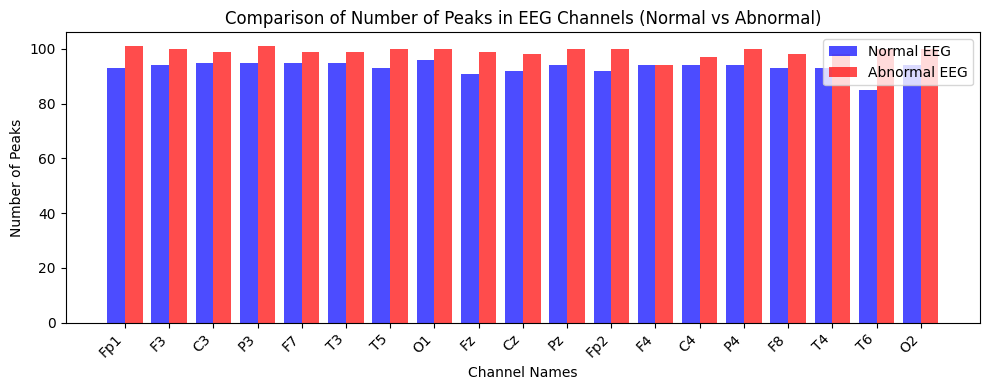

In [ ]:
plot_peak_comparison(raw, raw_seizure)

In [ ]:
def count_spikes_in_channels(raw, threshold=100):
    picks = mne.pick_types(raw.info, meg=False, eeg=True)
    eeg_data, _ = raw[picks]

    num_channels = eeg_data.shape[0]
    num_samples = eeg_data.shape[1]

    spike_counts = []
    for i in range(num_channels):
        channel_data = eeg_data[i, :]
        # Detect spikes by finding local maxima above a specified threshold
        peaks, _ = find_peaks(channel_data, height=threshold, distance=100)  # Adjust 'distance' and 'height' parameters
        spike_counts.append(len(peaks))

    return spike_counts

def plot_spike_comparison(normal_raw, abnormal_raw, threshold=100):
    # Count spikes in each channel for normal and abnormal raw EEG objects
    normal_spike_counts = count_spikes_in_channels(normal_raw, threshold=threshold)
    abnormal_spike_counts = count_spikes_in_channels(abnormal_raw, threshold=threshold)

    channel_names = normal_raw.info['ch_names']
    num_channels = len(channel_names)

    # Plotting the comparison graph
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(num_channels) - 0.2, normal_spike_counts, width=0.4, label='Normal EEG', color='blue', alpha=0.7)
    plt.bar(np.arange(num_channels) + 0.2, abnormal_spike_counts, width=0.4, label='Abnormal EEG', color='red', alpha=0.7)

    plt.xlabel('Channel Names')
    plt.ylabel('Number of Spikes')
    plt.title('Comparison of Number of Spikes in EEG Channels (Normal vs Abnormal)')
    plt.xticks(ticks=np.arange(num_channels), labels=channel_names, rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.show()


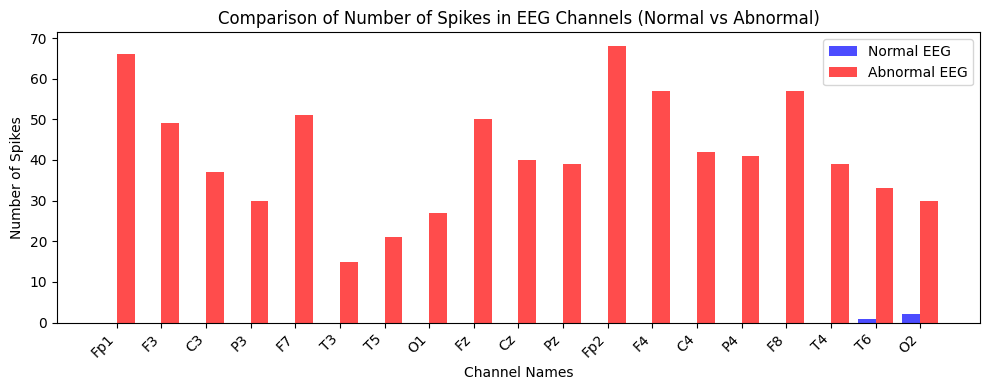

In [ ]:
plot_spike_comparison(raw, raw_seizure, threshold=100)


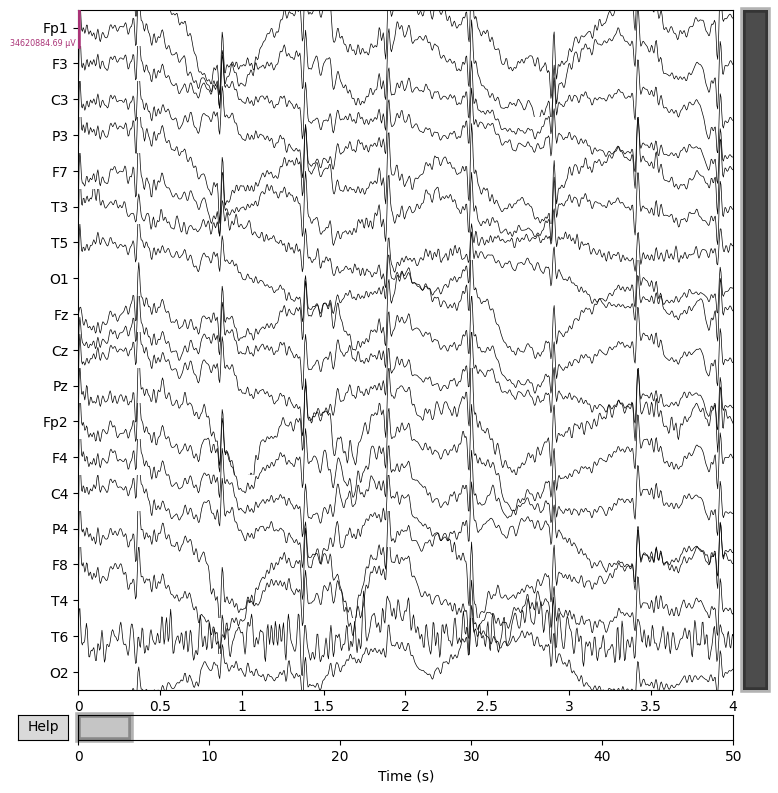

AttributeError: No mne.viz attribute show

In [ ]:
raw.plot(start=0, duration=4, scalings='auto', title='Raw EEG Data')
mne.viz.show()